In [1]:
################################################
###
### test SH decomposition for organoid data
###
################################################

In [1]:
from sys import argv, exit
import numpy as np
import pyshtools

from vedo import printc, load, spher2cart, mag, ProgressBar, Points, write
from vedo import *

#from scipy.interpolate import griddata

In [3]:
from skimage.io import imread
from skimage.io import imsave
#from skimage import filters
#from skimage import morphology
#from pyclesperanto_prototype import imshow
#import pyclesperanto_prototype as cle
#import matplotlib.pyplot as plt

RuntimeError: Unable to configure default ndarray.__repr__

#### import pyshtools
import gc
import numpy as np
import os
from vedo import printc, spher2cart
#from vedo import probePoints
import shutil
from sys import exit


def confirm(message):
    """
    Ask user to enter Y or N (case-insensitive).

    :return: True if the answer is Y.
    :rtype: bool
    """
    answer = ""
    while answer not in ["y", "n"]:
        answer = input(message).lower()
    return answer == "y"


def pathExists(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
        printc("Directory ", path, " Created ", c='green')
    else:
        printc("Directory ", path, " already exists", c='red')
        if confirm("Should I delete the folder and create a new one [Y/N]? "):
            shutil.rmtree(path)
            os.makedirs(path, exist_ok=True)
            printc("Directory ", path, " Created ", c='green')
        else:
            exit()


def voxelIntensity(vol, expo, N, radiusDiscretisation):
    """Compute voxel intensities."""
    pos = vol.center()
    rmax = vol.diagonalSize()/2

    scalars = []

    for th in np.linspace(0, np.pi, N, endpoint=False):
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):

            # compute sample points
            p = spher2cart(rmax, th, ph)
            samplePointsTmp = []
            # making discretization more dense away from the center
            p_tmp = p / (radiusDiscretisation-1)**expo
            for j in range(radiusDiscretisation):
                SP = pos + p_tmp * (j**expo)
                samplePointsTmp.append(SP)

            # compute intensities
            pb = probePoints(vol, samplePointsTmp)

            del samplePointsTmp

            # making the intensities growing outside the volume according to the gradient
            scalarsTmp = pb.getPointArray()
            nonz = np.nonzero(scalarsTmp)[0]
            if len(nonz) > 2:
                lastNoZeroId = nonz[-1]  # find the last value != 0
                secondlastNoZeroId = nonz[-2]
                # find the last value != 0
                lastNoZero = scalarsTmp[lastNoZeroId]
                secondlastNoZero = scalarsTmp[secondlastNoZeroId]
                dx = lastNoZero - secondlastNoZero

            for i in range(lastNoZeroId+1, len(scalarsTmp)):
                scalarsTmp[i] = scalarsTmp[i-1] + dx
            scalars.append(scalarsTmp.tolist())

            del pb, scalarsTmp

    del vol
    gc.collect()

    # return allIntensitiesMatrix
    return np.array(scalars).reshape((N * N, radiusDiscretisation))


def forwardTransformation(matrixOfIntensities, N, lmax):

    ##############################################

    coeff = matrixOfIntensities

    ##############################################
    # SPHARNM
    allClm = np.zeros((matrixOfIntensities.shape[1], 2, lmax, lmax))
    for j in range(allClm.shape[0]):
        formattedcoeff = np.reshape(coeff[:, j], (N, N))
        SH = pyshtools.SHGrid.from_array(formattedcoeff)
        clm = SH.expand()

        allClm[j, :, :, :] = clm.to_array(lmax=lmax - 1)

    del formattedcoeff, clm, matrixOfIntensities

    return allClm


def inverseTransformations(allClm, allIntensitiesShape, N, lmax):
    """Make inverse SPHARM."""
    from scipy.interpolate import griddata

    aSH_recoMatrix = np.zeros((allIntensitiesShape[0], allIntensitiesShape[1]))

    for j in range(allClm.shape[0]):
        # inverse SPHARM coefficients
        clmCoeffs = pyshtools.SHCoeffs.from_array(allClm[j, :, :, :])
        SH_reco = clmCoeffs.expand(lmax=lmax - 1)
        # grid_reco.plot()
        aSH_reco = SH_reco.to_array()

        ##############################
        pts1 = []
        ll = []
        for ii, long in enumerate(np.linspace(0, 360, num=aSH_reco.shape[1], endpoint=True)):
            for jj, lat in enumerate(np.linspace(90, -90, num=aSH_reco.shape[0], endpoint=True)):
                th = np.deg2rad(90 - lat)
                ph = np.deg2rad(long)
                p = spher2cart(aSH_reco[jj][ii], th, ph)
                pts1.append(p)
                ll.append((lat, long))

        radii = aSH_reco.T.ravel()

        # make a finer grid
        n = N * 1j
        l_min, l_max = np.array(ll).min(axis=0), np.array(ll).max(axis=0)
        grid = np.mgrid[l_max[0]:l_min[0]:n, l_min[1]:l_max[1]:n]
        grid_x, grid_y = grid
        agrid_reco_finer = griddata(ll, radii, (grid_x, grid_y), method='cubic')
        ##############################

        formatted_aSH_reco = np.reshape(agrid_reco_finer, (N * N))

        aSH_recoMatrix[:, j] = formatted_aSH_reco

    del formatted_aSH_reco, agrid_reco_finer, grid_x, grid_y, grid

    return aSH_recoMatrix


def samplePoints(vol, expo, N, radiusDiscretisation):
    """Compute sample points."""
    pos = vol.center()
    rmax = vol.diagonalSize()/2

    samplePoints = []
    for th in np.linspace(0, np.pi, N, endpoint=False):
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):

            # compute sample points
            p = spher2cart(rmax, th, ph)
            # making discretization more dense away from the center
            p_tmp = p / (radiusDiscretisation-1)**expo
            for j in range(radiusDiscretisation):
                SP = pos + p_tmp * (j**expo)
                samplePoints.append(SP)

    del vol

    return np.array(samplePoints)

In [4]:
def computeCLM(mesh, rmax, N, x0):
    """Compute CLM."""
    # cast rays from the center and find intersections
    agrid, pts = [], []
    for th in np.linspace(0, np.pi, N, endpoint=False):
        lats = []
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):
            p = spher2cart(rmax, th, ph)
            intersections = mesh.intersect_with_line(x0, x0 + p)
            if len(intersections):
                value = mag(intersections[0]-x0)
                lats.append(value)
                pts.append(intersections[0])
            else:
                lats.append(rmax)
                # lats.append(0)
                pts.append(p)
        agrid.append(lats)
    agrid = np.array(agrid)

    grid = pyshtools.SHGrid.from_array(agrid)
    clm = grid.expand()
    # grid_reco = clm.expand(lmax=lmax)  # cut "high frequency" components

    return clm

In [6]:
lmax = 20
N = 500          # number of grid intervals on the unit sphere
rmax = 1400
x0 = [0, 0, 0]  # set object at this position
xLimb = [-200, 0, 200]
cutOrigin = [150, 0, 0]
deg_fit = 6

In [7]:
CPoutDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/test_WTd6"
WTDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/test_WTd6" 

#CPoutDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/CPouts2"
#ImageDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/d4_10x_Pax6KO_WTchim" 

In [8]:
#DataPath = '/Users/jingkui.wang/workspace/imp/image_analysis/S-BIAD441/limbs/limbs-noFlank/'
path_results = 'res/' \
        + 'test_organoid_WTd6' + '/'


pathExists(path_results)

printc('lmax =', lmax, 'N =', N, 'deg_fit =', deg_fit, c='y')

Directory  res/test_organoid_WTd6/  already exists


Should I delete the folder and create a new one [Y/N]?  N


SystemExit: 

/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [201]:
outDir = path_results

In [214]:
fileName = '20220727_d6_10x_RA-18h_E2_121_1981_isotropic'
#fileName = '241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01_isotropic'

In [215]:
mask = imread(os.path.join(CPoutDir, str(fileName + "_C4_CystMask.tiff"))) # mask segmeted cysts
C3 = imread(os.path.join(WTDir, str(fileName + "_C3.tif"))) # FoxA2, nuclei
C2 = imread(os.path.join(WTDir, str(fileName + "_C2.tif"))) # Pax6, nuclei
C4 = imread(os.path.join(WTDir, str(fileName + "_C4.tif"))) # Dapi, nuclei

#C3 = C3 / np.quantile(C3, 0.95)
#C2 = C2 / np.quantile(C2, 0.95)
#C4 = C4 / np.quantile(C4, 0.95)

In [216]:
#mask = imread(os.path.join(CPoutDir, str(fileName + "_C5_CystMask.tiff"))) # mask segmeted cysts
#C1 = imread(os.path.join(CPoutDir, str(fileName + "_FoxA2mask.tiff"))) # FoxA2, nuclei
#C2 = imread(os.path.join(CPoutDir, str(fileName + "_P6KOSCmask.tiff"))) # Pax6-KO genotype Scarlet, nuclei
#C3 = imread(os.path.join(CPoutDir, str(fileName + "_WTGFPmask.tiff"))) # WT genotype GFP, whole cell 
#C4 = imread(os.path.join(CPoutDir, str(fileName + "_Pax6mask.tiff"))) # Pax6, nuclei
#C1 = imread(os.path.join(ImageDir, str(fileName + "_C1.tif"))) # FoxA2, nuclei
#C2 = imread(os.path.join(ImageDir, str(fileName + "_C2.tif"))) # Pax6-KO genotype Scarlet, nuclei
#C3 = imread(os.path.join(ImageDir, str(fileName + "_C3.tif"))) # WT genotype GFP, whole cell 
#C4 = imread(os.path.join(ImageDir, str(fileName + "_C4.tif"))) # Pax6, nuclei
#C1 = C1 / np.quantile(C1, 0.99)
#C2 = C2 / np.quantile(C2, 0.99)
#C3 = C3 / np.quantile(C3, 0.99)
#C4 = C4 / np.quantile(C4, 0.99)

In [217]:
from skimage import measure
import pandas as pd
from skimage.filters import threshold_otsu, rank
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [218]:
import napari
from napari.utils import nbscreenshot

In [219]:
cle.available_device_names()

['Apple M1 Max']

In [220]:
# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

<Apple M1 Max on Platform: Apple (2 refs)>

In [221]:
labels_mask, nb_cyst = measure.label(mask, return_num = True)

In [222]:
#from skimage.measure import label, regionprops
#props = regionprops(labels_mask)
#props
#props[0].pixelcount

In [223]:
nb_cyst

29

In [224]:
cyst_index = np.where(labels_mask == 1)
cyst_index[0].size
#genotype_wt = C3[cyst_index]
#genotype_ko = C2[cyst_index]

100898

In [225]:
#cyst_index[0].size

In [22]:
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(C3))
viewer.add_labels(cle.pull(labels_mask))


/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


<Labels layer 'labels_mask' at 0x2d77f9e80>

In [226]:
cyst_index = 2
[z, rows, columns] = np.where(labels_mask == cyst_index)
z1 = min(z)
z2 = max(z)
row1 = min(rows)
row2 = max(rows)
col1 = min(columns)
col2 = max(columns)

In [228]:
xx = np.where(labels_mask == cyst_index, C3, 0)
newImage_foxa2 = xx[z1:z2, row1:row2, col1:col2]

xx = np.where(labels_mask == cyst_index, C4, 0)
newImage_dapi = xx[z1:z2, row1:row2, col1:col2]

xx = np.where(labels_mask == cyst_index, labels_mask, 0)
newImage_cyst = xx[z1:z2, row1:row2, col1:col2]



In [229]:
newImage_cyst.shape
print(newImage_cyst.min())
print(newImage_cyst.max())

0
2


In [232]:
imsave(os.path.join(outDir, str(fileName + "_cyst_2_channel_FoxA2.tif")), newImage_foxa2)
imsave(os.path.join(outDir, str(fileName + "_cyst_2_channel_dapi.tif")), newImage_dapi)

/var/folders/ld/7f_9j5n17vs69r90p179ws240000gp/T/ipykernel_86223/1337608745.py:1: UserWarning: res/test_organoid_WTd6/20220727_d6_10x_RA-18h_E2_121_1981_isotropic_cyst_2_channel_FoxA2.tif is a low contrast image
  imsave(os.path.join(outDir, str(fileName + "_cyst_2_channel_FoxA2.tif")), newImage_foxa2)


In [233]:
outDir

'res/test_organoid_WTd6/'

In [135]:
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(newImage_cyst))
viewer.add_image(cle.pull(newImage_foxa2))
viewer.add_image(cle.pull(newImage_dapi))

<Image layer 'newImage_dapi' at 0x33fb6f1f0>

In [158]:
#test = newImage_cyst/newImage_cyst.max() +  newImage_foxa2
test = newImage_dapi + newImage_foxa2

In [161]:
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(newImage_cyst))
viewer.add_image(cle.pull(newImage_foxa2))
viewer.add_image(cle.pull(newImage_dapi))
viewer.add_image(cle.pull(test))


<Image layer 'test' at 0x319419df0>

In [159]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(volume = test, step_size = 1)

(0.0, 50.0)

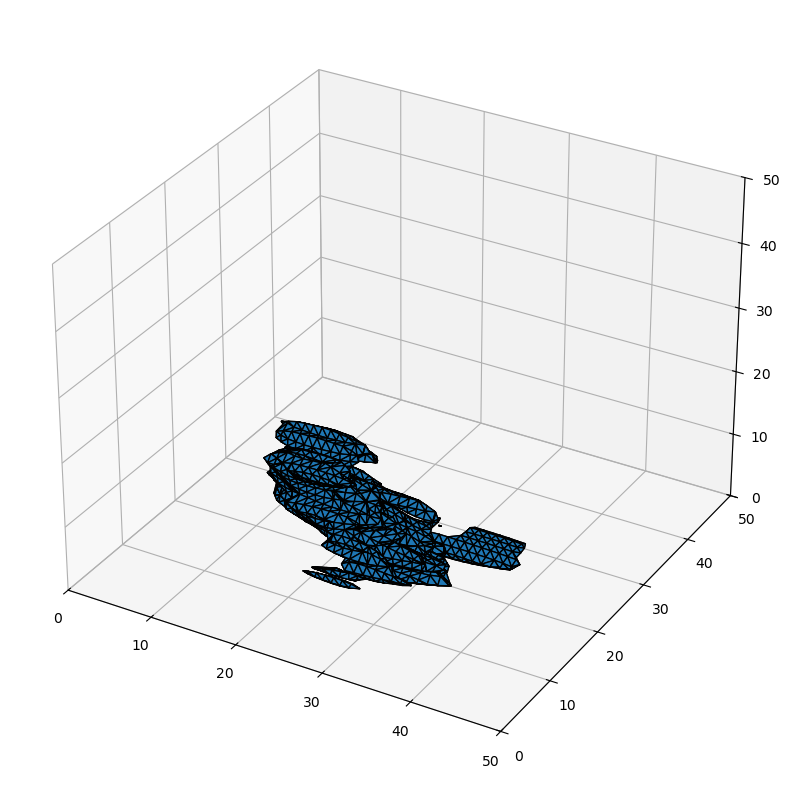

In [160]:
mesh = Poly3DCollection(verts[faces])

mesh.set_edgecolor('k')
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
ax.add_collection3d(mesh)

#ax.set_xlabel("x-axis: a = 6 per ellipsoid")
#ax.set_ylabel("y-axis: b = 10")
#ax.set_zlabel("z-axis: c = 16")
ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 50)  # b = 10
ax.set_zlim(0, 50)  # c = 16

#plt.tight_layout()
#plt.show()


In [121]:
newImage_foxa2.shape

(49, 47, 41)

(0.0, 50.0)

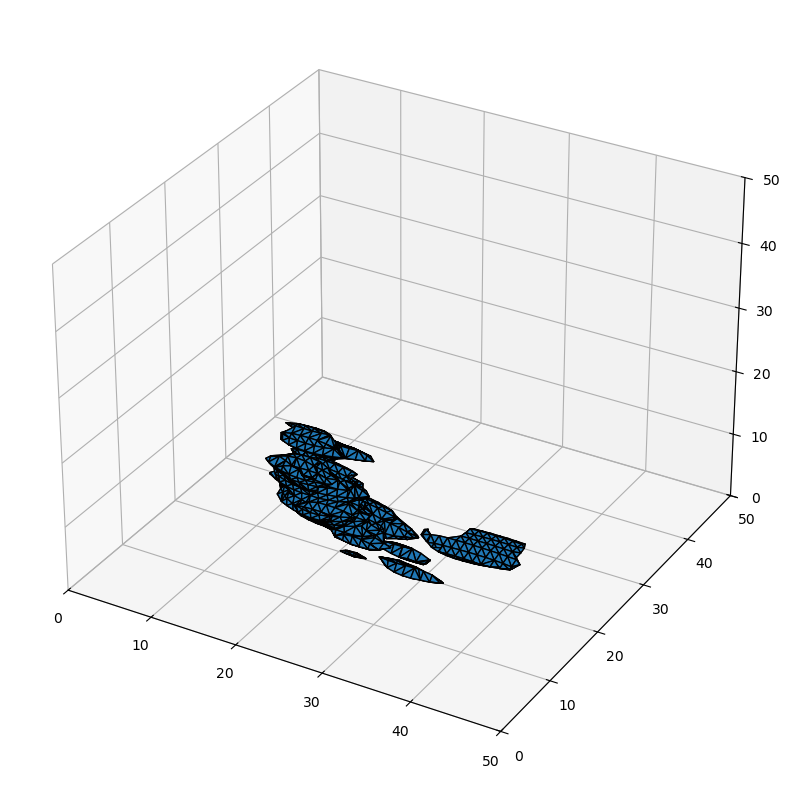

In [21]:
import napari
from napari.utils import nbscreenshot

In [18]:
## test marching cube algorith from scikit image 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...], ellip_base[2:, ...]), axis=0)

In [22]:
ellip_double.shape
#ellip_base.shape

(27, 23, 35)

In [24]:
viewer = napari.Viewer()
# show images
viewer.add_image(cle.pull(ellip_base))

<Image layer 'ellip_base' at 0x2b79c77c0>

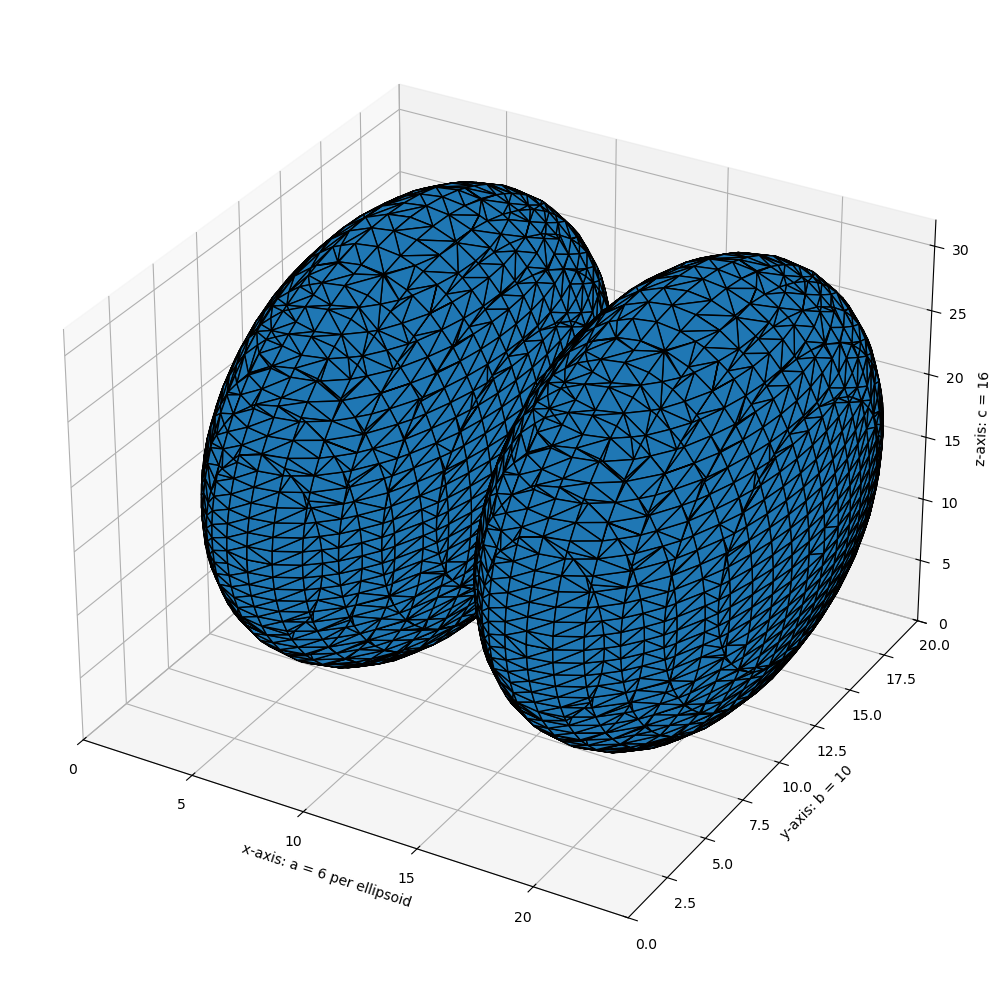

In [35]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()


(20156,)

<Labels layer 'labels_mask' at 0x324cd2a90>

In [1]:
import numpy as np

from dipy.core.sphere import HemiSphere, Sphere, disperse_charges
from dipy.data import get_sphere
from dipy.reconst.shm import sf_to_sh, sh_to_sf
from dipy.sims.voxel import multi_tensor_odf


/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
from dipy.viz import actor, window

In [3]:
rng = np.random.default_rng()
n_pts = 64
theta = np.pi * rng.random(n_pts)
phi = 2 * np.pi * rng.random(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)


In [4]:
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
sphere = Sphere(xyz=np.vstack((hsph_updated.vertices, -hsph_updated.vertices)))


In [5]:
mevals = np.array([[0.0015, 0.00015, 0.00015], [0.0015, 0.00015, 0.00015]])
angles = [(0, 0), (60, 0)]
odf = multi_tensor_odf(sphere.vertices, mevals, angles, [50, 50])

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()
scene.SetBackground(1, 1, 1)

odf_actor = actor.odf_slicer(odf[None, None, None, :], sphere=sphere)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving illustration as symm_signal.png")
window.record(scene=scene, out_path="symm_signal.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving illustration as symm_signal.png


In [6]:
# Change this value to try out other bases
sh_basis = "descoteaux07"
# Change this value to try other maximum orders
sh_order_max = 8

sh_coeffs = sf_to_sh(odf, sphere, sh_order_max=sh_order_max, basis_type=sh_basis)


In [7]:
high_res_sph = get_sphere(name="symmetric724").subdivide(n=2)
reconst = sh_to_sf(
    sh_coeffs, high_res_sph, sh_order_max=sh_order_max, basis_type=sh_basis
)

scene.clear()
odf_actor = actor.odf_slicer(reconst[None, None, None, :], sphere=high_res_sph)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as symm_reconst.png")
window.record(scene=scene, out_path="symm_reconst.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as symm_reconst.png


In [8]:
mevals = np.array([[0.0015, 0.0003, 0.0003]])
angles = [(0, 0)]
odf2 = multi_tensor_odf(sphere.vertices, mevals, angles, [100])

n_pts_hemisphere = int(sphere.vertices.shape[0] / 2)
asym_odf = np.append(odf[:n_pts_hemisphere], odf2[n_pts_hemisphere:])

scene.clear()
odf_actor = actor.odf_slicer(asym_odf[None, None, None, :], sphere=sphere)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as asym_signal.png")
window.record(scene=scene, out_path="asym_signal.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as asym_signal.png


In [9]:
sh_coeffs = sf_to_sh(asym_odf, sphere, sh_order_max=sh_order_max, basis_type=sh_basis)
reconst = sh_to_sf(
    sh_coeffs, high_res_sph, sh_order_max=sh_order_max, basis_type=sh_basis
)

scene.clear()
odf_actor = actor.odf_slicer(reconst[None, None, None, :], sphere=high_res_sph)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as asym_reconst.png")
window.record(scene=scene, out_path="asym_reconst.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as asym_reconst.png


In [10]:
sh_coeffs = sf_to_sh(
    asym_odf, sphere, sh_order_max=sh_order_max, basis_type=sh_basis, full_basis=True
)
reconst = sh_to_sf(
    sh_coeffs,
    high_res_sph,
    sh_order_max=sh_order_max,
    basis_type=sh_basis,
    full_basis=True,
)

scene.clear()
odf_actor = actor.odf_slicer(reconst[None, None, None, :], sphere=high_res_sph)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as asym_reconst_full.png")
window.record(scene=scene, out_path="asym_reconst_full.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as asym_reconst_full.png


In [162]:
# from https://github.com/marcomusy/vedo/blob/master/examples/other/spherical_harmonics1.py
"""Expand and reconstruct any surface
(here a simple box) into spherical harmonics"""
# Expand an arbitrary closed shape into spherical harmonics
# using SHTOOLS (https://shtools.github.io/SHTOOLS)
# and then truncate the expansion to a specific lmax and
# reconstruct the projected points on a finer grid.
import pyshtools
import numpy as np
from scipy.interpolate import griddata
from vedo import spher2cart, mag, Box, Point, Points, Plotter



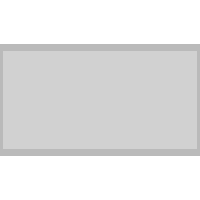

In [163]:
###########################################################################
lmax = 8              # maximum degree of the spherical harm. expansion
N    = 50             # number of grid intervals on the unit sphere
rmax = 500            # line length
x0 = [250, 250, 250]  # set SPH sphere at this position
###########################################################################

x0 = np.array(x0)
surface = Box(pos=x0+[10,20,30], size=(300,150,100))
surface.color('grey').alpha(0.2)

In [164]:
############################################################
# cast rays from the sphere center and find intersections
agrid, pts = [], []
for th in np.linspace(0, np.pi, N, endpoint=True):
    longs = []
    for ph in np.linspace(0, 2*np.pi, N, endpoint=False):
        p = spher2cart(rmax, th, ph)
        intersections = surface.intersect_with_line(x0, x0+p)
        if len(intersections):
            value = mag(intersections[0]-x0)
            longs.append(value)
            pts.append(intersections[0])
        else:
            print('No hit for theta, phi =', th, ph, c='r')
            longs.append(rmax)
            pts.append(p)
    agrid.append(longs)
agrid = np.array(agrid)

hits = Points(pts)
hits.cmap('jet', agrid.ravel()).add_scalarbar3d('scalar distance to x_0')
hits.scalarbar = hits.scalarbar.clone2d(size=0.12)

In [165]:
#############################################################
grid = pyshtools.SHGrid.from_array(agrid)
clm = grid.expand()
grid_reco = clm.expand(lmax=lmax).to_array()  # cut "high frequency" components


In [166]:
#############################################################
# interpolate to a finer grid
ll = []
for i, long in enumerate(np.linspace(0, 360, num=grid_reco.shape[1], endpoint=False)):
    for j, lat in enumerate(np.linspace(90, -90, num=grid_reco.shape[0], endpoint=True)):
        th = np.deg2rad(90 - lat)
        ph = np.deg2rad(long)
        p = spher2cart(grid_reco[j][i], th, ph)
        ll.append((lat, long))

radii = grid_reco.T.ravel()
n = 200j
lnmin, lnmax = np.array(ll).min(axis=0), np.array(ll).max(axis=0)
grid = np.mgrid[lnmax[0]:lnmin[0]:n, lnmin[1]:lnmax[1]:n]
grid_x, grid_y = grid
grid_reco_finer = griddata(ll, radii, (grid_x, grid_y), method='cubic')

pts2 = []
for i, long in enumerate(np.linspace(0, 360, num=grid_reco_finer.shape[1], endpoint=False)):
    for j, lat in enumerate(np.linspace(90, -90, num=grid_reco_finer.shape[0], endpoint=True)):
        th = np.deg2rad(90 - lat)
        ph = np.deg2rad(long)
        p = spher2cart(grid_reco_finer[j][i], th, ph)
        pts2.append(p+x0)

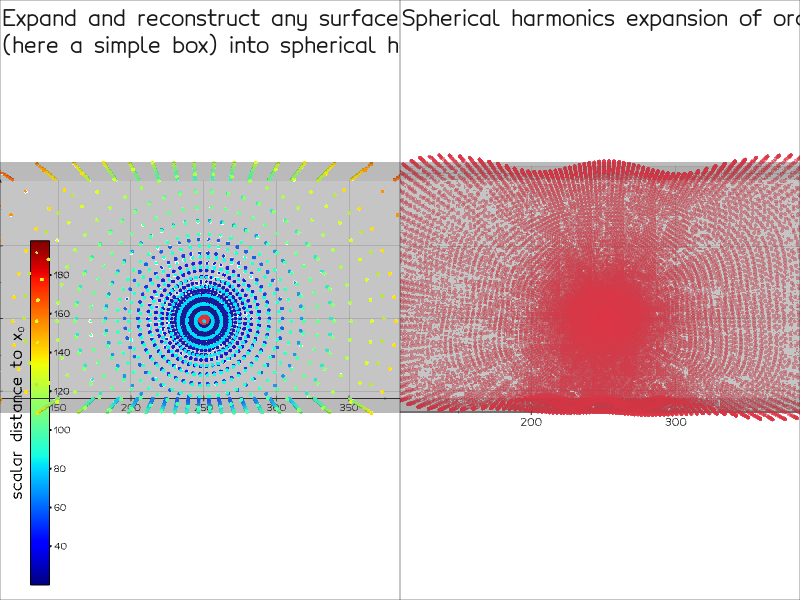

In [168]:
plt = Plotter(N=2, axes=1)
plt.at(0).show(surface, hits, Point(x0), __doc__)
plt.at(1).show(
    f'Spherical harmonics expansion of order {lmax}',
    Points(pts2).c("red5").alpha(0.5),
    surface,
)



In [169]:
plt.interactive().close()

In [170]:
"""Glyphs:
at each vertex of a mesh, another mesh
is shown with various orientation options
# https://github.com/marcomusy/vedo/blob/master/examples/basic/glyphs1.py
"""
from vedo import *

# Create a sphere with resolution 12, set its color and show as wireframe
sph = Sphere(res=12).c("white", 0.1).wireframe()

randvs = np.random.rand(sph.npoints, 3)  # random orientation vectors

#######################################
# Create an ellipsoid glyph and scale it down
gly1 = Ellipsoid().scale(0.04)

# create a Glyph object that will show an ellipsoid at each vertex
gsphere1 = Glyph(
    sph,
    gly1,
    orientation_array=randvs,
    scale_by_vector_size=True,
    color_by_vector_size=True,
    c="jet",
)

#######################################
# Create a mesh glyph and scale it down
gly2 = Mesh(dataurl + "shuttle.obj").rotate_y(180).scale(0.02)

# Create a Glyph object that will show a shuttle at each vertex
gsphere2 = Glyph(
    sph,
    gly2,
    orientation_array="normals",
    c="lightblue",
)



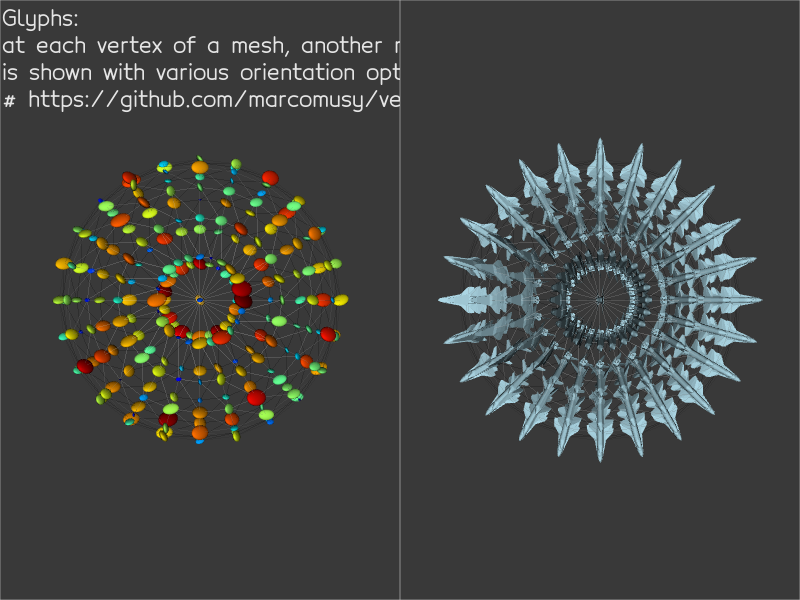

In [172]:
# Show two groups of objects on N=2 renderers:
show([
        (sph, gsphere1, __doc__),
        (sph, gsphere2)
    ],
    N=2, 
    bg="bb", 
    zoom=1.4,
)

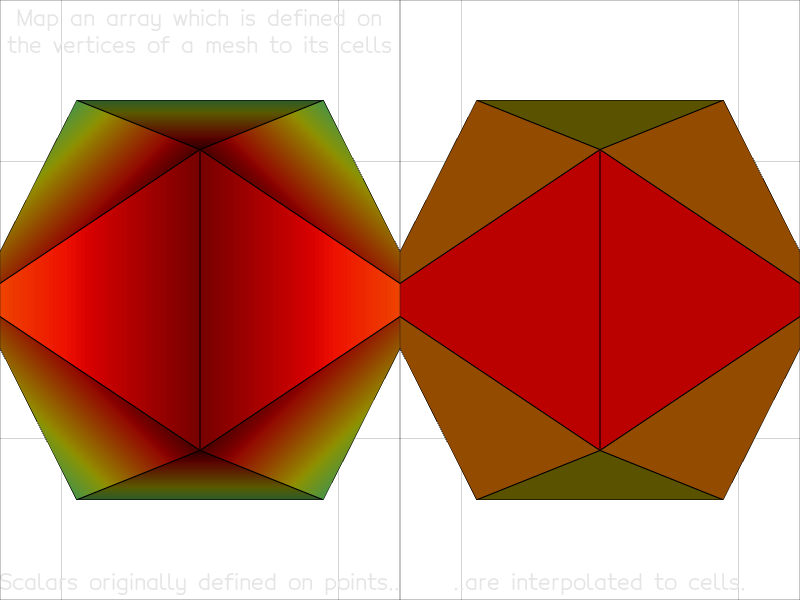

In [173]:
"""Map an array which is defined on
the vertices of a mesh to its cells"""
from vedo import *

doc = Text2D(__doc__, pos="top-center")

mesh1 = Mesh(dataurl+'icosahedron.vtk').linewidth(0.1).flat()

# let the scalar be the z coordinate of the mesh vertices
msg1 = Text2D("Scalars originally defined on points..", pos="bottom-center")
mesh1.pointdata["myzscalars"] = mesh1.vertices[:, 2]

mesh1.cmap("jet", "myzscalars", on="points")

msg2 = Text2D("..are interpolated to cells.", pos="bottom-center")
mesh2 = mesh1.clone(deep=False).map_points_to_cells()

plt = Plotter(N=2, axes=11)
plt.at(0).show(mesh1, msg1, doc, viewup="z")
plt.at(1).show(mesh2, msg2)
#plt.interactive().close()

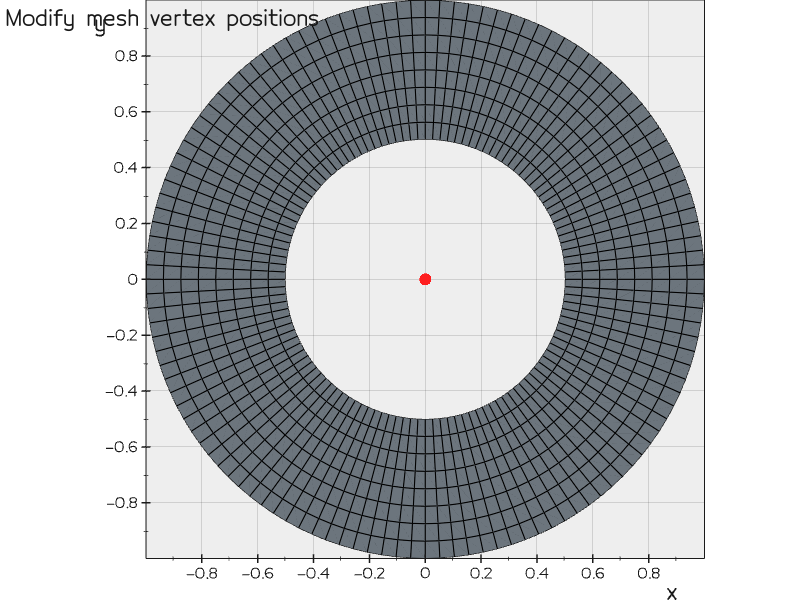

In [176]:
"""Modify mesh vertex positions"""
from vedo import *

disc = Disc(res=(8,120)).linewidth(1)

plt = Plotter(interactive=False, axes=1)
plt.show(disc, Point(), __doc__)


In [177]:
for i in range(100):
    # Modify vertex positions
    disc.vertices += [0.01, 0.01*sin(i/20), 0]
    
    plt.reset_camera().render()

plt.interactive().close()

AttributeError: 'NoneType' object has no attribute 'GetInitialized'

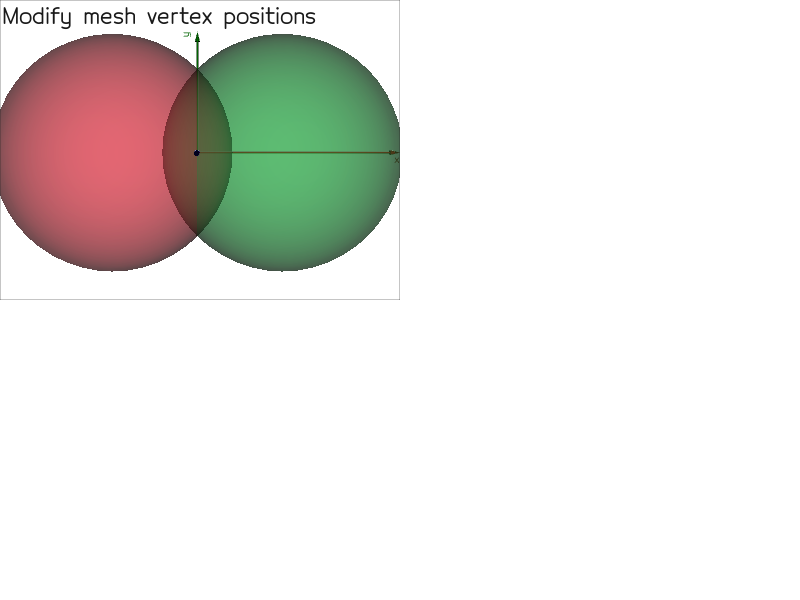

In [179]:
from vedo import *

# Enable depth peeling for rendering transparency
settings.use_depth_peeling = True

# Declare an instance of the Plotter class with 2 rows and 2 columns of renderers,
# and disable interactive mode, so that the program can continue running
plt = Plotter(shape=(2, 2), interactive=False, axes=3)
# Create two sphere meshes
s1 = Sphere(pos=[-0.7, 0, 0]).c("red5",0.5)
s2 = Sphere(pos=[0.7, 0, 0]).c("green5",0.5)

# Show the spheres on the first renderer, and display the docstring as the title
plt.at(0).show(s1, s2, __doc__)

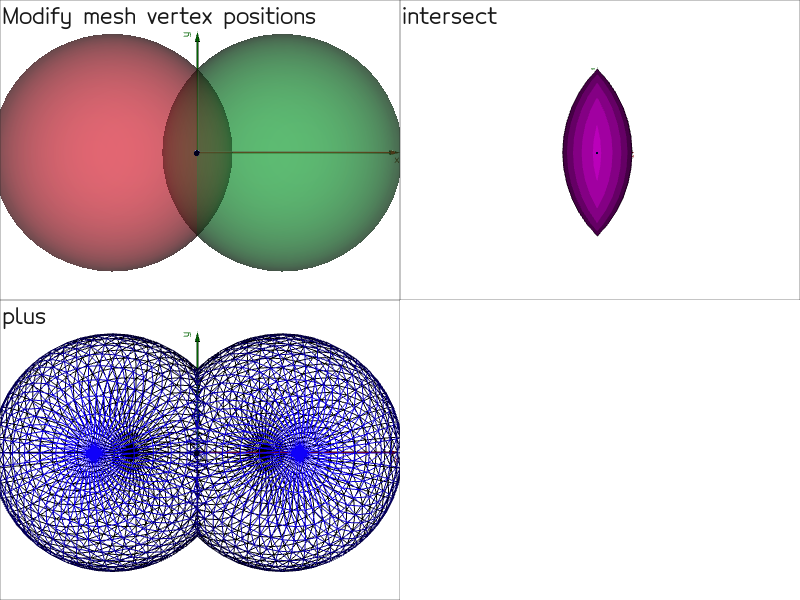

In [180]:
# Perform a boolean intersection operation between the two spheres,
# set the color to magenta, and show the result on the second renderer
b1 = s1.boolean("intersect", s2).c('magenta')
plt.at(1).show(b1, "intersect", resetcam=False)

# Perform a boolean union operation between the two spheres,
# set the color to blue, add a wireframe, and show the result on the third renderer
b2 = s1.boolean("plus", s2).c("blue").wireframe(True)
plt.at(2).show(b2, "plus", resetcam=False)



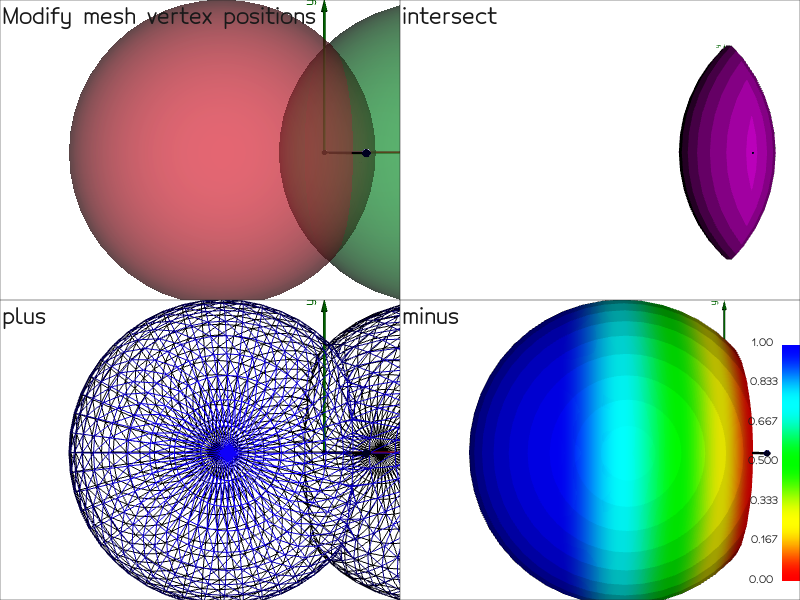

In [181]:
# Perform a boolean difference operation between the two spheres,
# compute the normals, add a scalarbar, and show the result on the fourth renderer
b3 = s1.boolean("minus", s2).compute_normals().add_scalarbar(c='white')
plt.at(3).show(b3, "minus", resetcam=False)



In [182]:
# Enable interactive mode, and close the plot
plt.interactive().close()

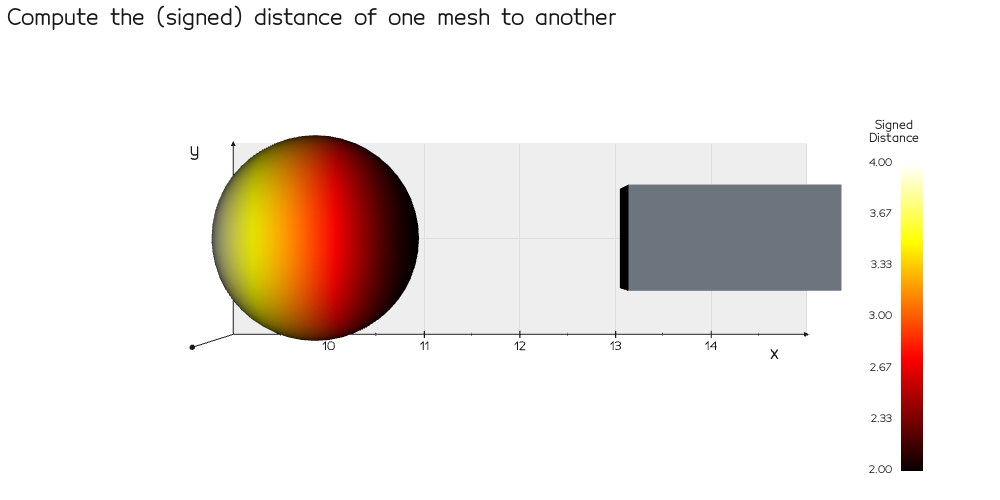

In [184]:
"""Compute the (signed) distance of one mesh to another"""
from vedo import Sphere, Cube, show

# Create a sphere object and position it at (10,20,30)
s1 = Sphere().pos(10,20,30)

# Create a cube object with color grey and scaled 
# along the x-axis by 2, and positioned at (14,20,30)
s2 = Cube(c='grey4').scale([2,1,1]).pos(14,20,30)

# Compute the Euclidean distance between the 2 surfaces
# and set the color of the sphere based on the distance
s1.distance_to(s2, signed=False)
s1.cmap('hot').add_scalarbar('Signed\nDistance')

# Show the sphere, the cube, the script docstring, axes,
# then close the window
show(s1, s2, __doc__ , axes=1, size=(1000,500), zoom=1.5)

In [185]:
"""
Takes 2 shapes, source and target, and morphs source on target
this is obtained by fitting 18 parameters of a non linear,
quadratic, transformation defined in transform()
The fitting minimizes the distance to the target surface
using algorithms available in the scipy.optimize package.
"""
from vedo import dataurl, vector, mag2, mag
from vedo import Plotter, Sphere, Point, Text3D, Arrows, Mesh
import scipy.optimize as opt

In [186]:
print(__doc__)


class Morpher:
    def __init__(self):
        self.source = None
        self.target = None
        self.bound = 0.1
        self.method = "SLSQP"  # 'SLSQP', 'L-BFGS-B', 'TNC' ...
        self.tolerance = 0.0001
        self.subsample = 200  # pick only subsample pts
        self.allow_scaling = False
        self.params = []
        self.msource = None
        self.s_size = ([0, 0, 0], 1)  # ave position and ave size
        self.fitResult = None
        self.chi2 = 1.0e10
        self.plt = None

    # -------------------------------------------------------- fit function
    def transform(self, p):
        a1, a2, a3, a4, a5, a6, b1, b2, b3, b4, b5, b6, c1, c2, c3, c4, c5, c6, s = self.params
        pos, sz = self.s_size[0], self.s_size[1]
        x, y, z = (p - pos) / sz * s  # bring to origin, norm and scale
        xx, yy, zz, xy, yz, xz = x * x, y * y, z * z, x * y, y * z, x * z
        xp = x + 2 * a1 * xy + a4 * xx + 2 * a2 * yz + a5 * yy + 2 * a3 * xz + a6 * zz
        yp = +2 * b1 * xy + b4 * xx + y + 2 * b2 * yz + b5 * yy + 2 * b3 * xz + b6 * zz
        zp = +2 * c1 * xy + c4 * xx + 2 * c2 * yz + c5 * yy + z + 2 * c3 * xz + c6 * zz
        p2 = vector(xp, yp, zp)
        p2 = (p2 * sz) + pos  # take back to original size and position
        return p2

    def _func(self, pars):
        self.params = pars
        #calculate chi2
        d2sum, n = 0.0, self.source.npoints
        srcpts = self.source.vertices
        rng = range(0, n, int(n / self.subsample))
        for i in rng:
            p1 = srcpts[i]
            p2 = self.transform(p1)
            tp = self.target.closest_point(p2)
            d2sum += mag2(p2 - tp)
        d2sum /= len(rng)
        if d2sum < self.chi2:
            if d2sum < self.chi2 * 0.99:
                print("Emin ->", d2sum)
            self.chi2 = d2sum
        return d2sum

    # ------------------------------------------------------- Fit
    def morph(self):
        def avesize(pts):  # helper fnc
            s, amean = 0, vector(0, 0, 0)
            for p in pts:
                amean = amean + p
            amean /= len(pts)
            for p in pts:
                s += mag(p - amean)
            return amean, s / len(pts)

        print("\n..minimizing with " + self.method)
        self.msource = self.source.clone()

        self.s_size = avesize(self.source.vertices)
        bnds = [(-self.bound, self.bound)] * 18
        x0 = [0.0] * 18  # initial guess
        x0 += [1.0]  # the optional scale
        if self.allow_scaling:
            bnds += [(1.0 - self.bound, 1.0 + self.bound)]
        else:
            bnds += [(1.0, 1.0)]  # fix scale to 1
        res = opt.minimize(self._func, x0,
                           bounds=bnds, method=self.method, tol=self.tolerance)
        # recalc for all pts:
        self.subsample = self.source.npoints
        self._func(res["x"])
        print("\nFinal fit score", res["fun"])
        self.fitResult = res

    # ------------------------------------------------------- Visualization
    def draw_shapes(self):

        newpts = []
        for p in self.msource.vertices:
            newp = self.transform(p)
            newpts.append(newp)
        self.msource.vertices = newpts

        arrs = []
        pos, sz = self.s_size[0], self.s_size[1]
        sphere0 = Sphere(pos, r=sz, res=10, quads=True).wireframe().c("gray")
        for p in sphere0.vertices:
            newp = self.transform(p)
            arrs.append([p, newp])
        hair = Arrows(arrs, s=0.3, c='jet').add_scalarbar()

        zero = Point(pos).c("black")
        x1, x2, y1, y2, z1, z2 = self.target.bounds()
        tpos = [x1, y2, z1]
        text1 = Text3D("source vs target",  tpos, s=sz/10).color("dg")
        text2 = Text3D("morphed vs target", tpos, s=sz/10).color("db")
        text3 = Text3D("deformation",       tpos, s=sz/10).color("dr")

        self.plt = Plotter(shape=[1, 3], axes=1)
        self.plt.at(2).show(sphere0, zero, text3, hair)
        self.plt.at(1).show(self.msource, self.target, text2)
        self.plt.at(0).show(self.source, self.target, text1, zoom=1.2)
        self.plt.interactive().close()


Takes 2 shapes, source and target, and morphs source on target
this is obtained by fitting 18 parameters of a non linear,
quadratic, transformation defined in transform()
The fitting minimizes the distance to the target surface
using algorithms available in the scipy.optimize package.



In [187]:
mr = Morpher()
mr.source = Mesh(dataurl+"270.vtk").color("g",0.4)
mr.target = Mesh(dataurl+"290.vtk").color("b",0.3)
mr.target.wireframe()
mr.allow_scaling = True
mr.bound = 0.4  # limits the parameter value

mr.morph()

print("Result of parameter fit:\n", mr.params)


..minimizing with SLSQP
Emin -> 10451.244854891132
Emin -> 7464.813908861171
Emin -> 5172.922743405518
Emin -> 4280.990518475364
Emin -> 3808.5807110948217
Emin -> 2919.647314770434
Emin -> 2328.715798309529
Emin -> 2116.103489949038
Emin -> 1903.4806147483912
Emin -> 1759.0697458563243
Emin -> 1154.4233298695376
Emin -> 973.6954786986456
Emin -> 917.7120369377941
Emin -> 697.9611712403743
Emin -> 657.593434380024
Emin -> 612.5160806438475
Emin -> 587.0027681988269
Emin -> 552.2380935135157
Emin -> 536.9471708811437
Emin -> 507.6829166434992
Emin -> 486.6814515579205
Emin -> 466.87147970497557
Emin -> 457.90612817930486
Emin -> 441.07396065503355
Emin -> 419.3152386565535
Emin -> 411.77743337120285
Emin -> 403.68136988953495
Emin -> 399.2873097894558
Emin -> 393.71020371396406
Emin -> 389.1743493719177
Emin -> 379.5992215815857

Final fit score 378.0728487503032
Result of parameter fit:
 [-0.01187636  0.03039237 -0.05153142  0.16564266  0.03976278  0.30136294
  0.12838465 -0.00281116 

In [188]:
# now mr.msource contains the modified/morphed source.
mr.draw_shapes()

2025-01-27 15:38:56.313 (275242.773s) [         B8FAF40]vtkAttributeSmoothingFi:473   INFO|Executing constrained attribute filter
2025-01-27 15:38:56.313 (275242.774s) [         B8FAF40]    vtkExtractEdges.cxx:327   INFO|Executing edge extractor with original point numbering
2025-01-27 15:38:56.314 (275242.774s) [         B8FAF40]    vtkExtractEdges.cxx:388   INFO|Created 5100 edges



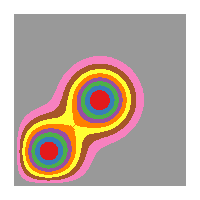

In [189]:
import numpy as np
from vedo import Grid, settings, show
from vedo.pyplot import histogram

settings.default_font = "FiraMonoMedium"

grid = Grid(res=[50,50])
grid.wireframe(False).lw(0)

values = np.zeros(grid.npoints)
values[int(grid.npoints/2)] = 1
values[int(grid.npoints/5)] = 1

grid.pointdata["scalars"] = values
grid.cmap("Set1_r").add_scalarbar()

grid2 = grid.clone()
grid2.smooth_data(niter=750, relaxation_factor=0.1, strategy=1)
grid2.cmap("Set1_r").add_scalarbar()

In [190]:
his = histogram(
    grid2.pointdata["scalars"],
    c='k4',
    xtitle="Concentration",
    ytitle="Frequency",
    axes=dict(htitle="", axes_linewidth=2, xyframe_line=0),
)
his = his.clone2d() # anchor it to screen coords

integrated over domain: {'pointdata': {'Normals': array([[0., 0., 1.]]), 'TextureCoordinates': array([[0.5, 0.5]]), 'scalars': array([0.00072165])}, 'celldata': {'Area': array([1.])}, 'metadata': {}}


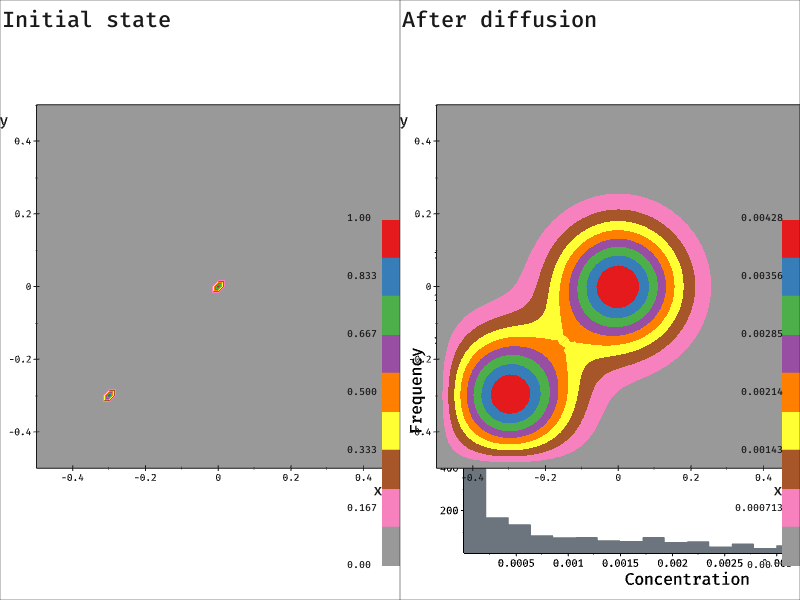

In [192]:
print("integrated over domain:", grid2.integrate_data())

show([
    ["Initial state", grid],
    ["After diffusion", grid2, his]],
    N=2, axes=1,
)

In [193]:
from vedo import *

# Load a Volume
vol = Volume(dataurl + 'embryo.slc')
vol.cmap('bone').mode(1)

# Create a Mesh (can be any mesh)
msh = Paraboloid(res=200).scale(200).pos([100,100,200])

# Probe the Volume with the Mesh
# and colorize it with the probed values
msh.probe(vol)
msh.cmap('Spectral').add_scalarbar().print()



vedo.shapes.Paraboloid at (0x3efc23770)                                    
name          : Paraboloid
elements      : vertices=36,288 polygons=72,166 lines=0
position      : (100.000, 100.000, 200.000)
scaling       : (200.000, 200.000, 200.000)
size          : average=94.4280, diagonal=355.575
center of mass: (100.000, 100.000, 87.4409)
bounds        : x=(-1.97, 202), y=(-1.97, 202), z=(0, 208)
pointdata *   : "SLCImage" (uint8), dim=1, range=(0, 145)
pointdata     : "ValidPointMask" (int8), dim=1, range=(0, 1.00)
pointdata     : "Normals" (float32), dim=3
pointdata     : "scalars" (float32), dim=1, range=(0.0100, 0.0100)
celldata      : "Normals" (float32), dim=3


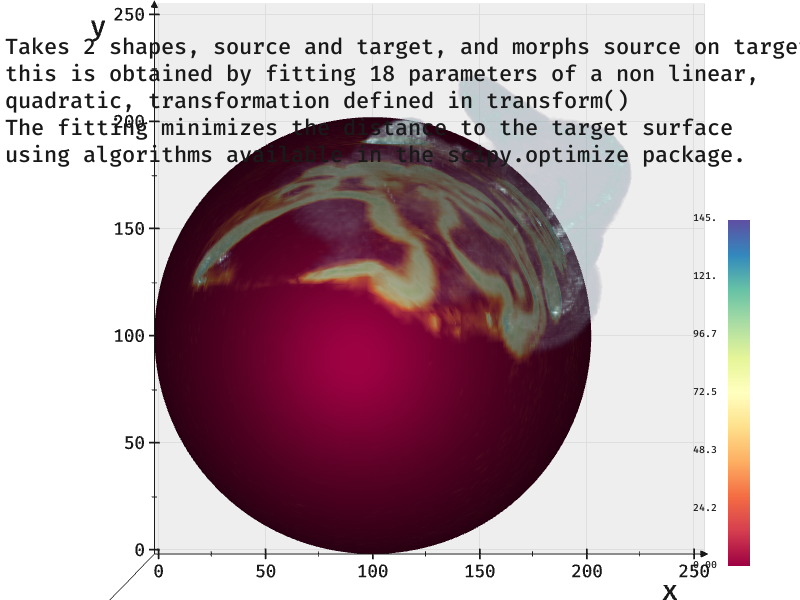

In [194]:
show(vol, msh, __doc__, axes=1)

In [195]:
"""Map an array which is defined on
the vertices of a mesh to its cells"""
from vedo import *

doc = Text2D(__doc__, pos="top-center")

mesh1 = Mesh(dataurl+'icosahedron.vtk').linewidth(0.1).flat()

# let the scalar be the z coordinate of the mesh vertices
msg1 = Text2D("Scalars originally defined on points..", pos="bottom-center")
mesh1.pointdata["myzscalars"] = mesh1.vertices[:, 2]

mesh1.cmap("jet", "myzscalars", on="points")

msg2 = Text2D("..are interpolated to cells.", pos="bottom-center")
mesh2 = mesh1.clone(deep=False).map_points_to_cells()



In [196]:
plt = Plotter(N=2, axes=11)

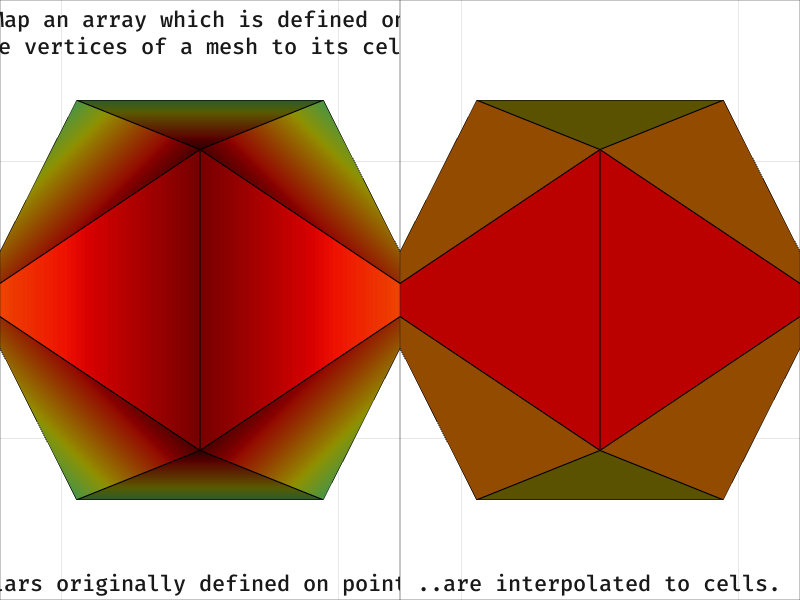

In [197]:
plt.at(0).show(mesh1, msg1, doc, viewup="z")
plt.at(1).show(mesh2, msg2)

In [198]:
"""Linearly transform a Mesh by defining how a specific
set of points (landmarks) must move"""
from vedo import dataurl, Mesh, Arrows, show

# Define the original set of landmark points
# note that landmark points do not need to belong to any mesh
landmarks1 = [
    [-0.067332, 0.177376, -0.05199058],
    [-0.004541, 0.085447,  0.05713107],
    [-0.011799, 0.175825, -0.02279279],
    [-0.081910, 0.117902,  0.04889364],
]

# Define the target set of landmark points
landmarks2 = [
    [0.1287002, 0.2651531, -0.0469673],
    [0.3338593, 0.0941488,  0.1243552],
    [0.1860555, 0.2626522, -0.0202493],
    [0.1149052, 0.1731894,  0.0474256],
]

s1 = Mesh(dataurl + "bunny.obj").c("gold")


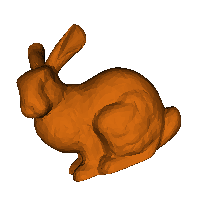

In [199]:
# Clone the mesh and color the clone orange
s2 = s1.clone().c('orange4')

# Transform the cloned mesh by moving the landmarks from landmarks1 to landmarks2
s2.align_with_landmarks(landmarks1, landmarks2)


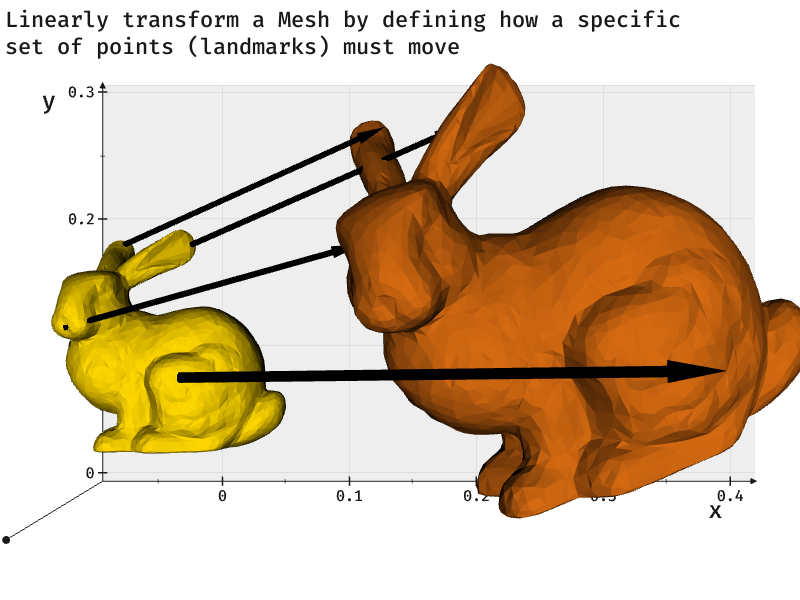

In [200]:
# Create arrows to visualize the movement of the landmark points
arrows = Arrows(landmarks1, landmarks2, s=0.5).c('black')

# Show the original mesh, transformed mesh, arrows, and script description
show(s1, s2, arrows, __doc__, axes=True)